# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [288]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 5
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)
#np.fill_diagonal(A, 1e-2)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (A - D) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [322]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [323]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [324]:
np.linalg.norm(BB)

281.5411039169222

### Do the Jacobi iteration

In [325]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [326]:
# Check the result:

A @ x - b

array([2.65473499e+117, 2.43339166e+117, 3.09853662e+117, 1.93371558e+117,
       2.05818714e+117])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [316]:
def f1(A,b,k): # Засовываем все вычисления, которые были ранее и выводим наш ответ и норму BB
    diag_1d = np.diag(A)
    B = -A.copy()
    np.fill_diagonal(B, 0)
    D = np.diag(diag_1d)
    invD = np.diag(1./diag_1d)
    BB = invD @ B 
    c = invD @ b
    n = len(A)
    n_iter = k
    x0 = np.ones(n)
    x = x0
    for _ in range(n_iter):
        x = BB @ x + c
    return A @ x - b, np.linalg.norm(BB)

In [295]:
A

array([[1.51915195e+01, 6.22108771e-01, 4.37727739e-01, 7.85358584e-01,
        7.79975808e-01],
       [2.72592605e-01, 1.52764643e+01, 8.01872178e-01, 9.58139354e-01,
        8.75932635e-01],
       [3.57817270e-01, 5.00995126e-01, 1.56834629e+01, 7.12702027e-01,
        3.70250755e-01],
       [5.61196186e-01, 5.03083165e-01, 1.37684496e-02, 1.57728266e+01,
        8.82641191e-01],
       [3.64885984e-01, 6.15396178e-01, 7.53812416e-02, 3.68824006e-01,
        1.59331401e+01]])

Видим, что диагоналные элементы доминируют над остальными, и норма матрицы меньше 1. И тогда получается, что сходимость у нас будет к корню.

In [244]:
f1(A,b,100)

(array([1.11022302e-16, 5.55111512e-17, 0.00000000e+00, 0.00000000e+00,
        1.11022302e-16]), 0.17396672093190155)

In [247]:
np.fill_diagonal(A, 1e-1)
A

array([[0.1       , 0.62210877, 0.43772774, 0.78535858, 0.77997581],
       [0.27259261, 0.1       , 0.80187218, 0.95813935, 0.87593263],
       [0.35781727, 0.50099513, 0.1       , 0.71270203, 0.37025075],
       [0.56119619, 0.50308317, 0.01376845, 0.1       , 0.88264119],
       [0.36488598, 0.61539618, 0.07538124, 0.36882401, 0.1       ]])

Сделаем теперь диагональные элементы сравнимыми с остальными и посмотрим, что будет тогда

In [248]:
f1(A,b,100)

(array([8.50178396e+132, 8.92686042e+132, 6.74843804e+132, 6.68788988e+132,
        5.45972494e+132]), 26.891031378379665)

Видно, что норма нашей матрицы превысила 1, из-за чего следует, что наш способ нахождения корня не сработает и он разойдется

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

In [249]:
def f2(A,b,x,n):
    A1 = np.tril(A) #np.tril(A) вырезает из матрица А все, что находится выше диагонали, то есть если выражаться
                    # в обозначениях этого метода, как на Вики, то np.tril(A) = L + D
                    # тогда наша матрица U = A - A1, нам надо из полной матрицы вычесть все, что выше диагонали и на ней
    U = A - A1      # И тогда просто домножением матрицы A1^(-1) получаем наши итерации
    x0 = x
    for i in range(n):
        x0 = np.linalg.inv(A1)@(-U@x0 + b)
    return x0

In [333]:
x1 = np.ones(5)  # пусть будет нашим приближением 

In [355]:
n = 5
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)
A

array([[1.57266585e+01, 9.00087837e-01, 7.79163801e-01, 5.99154781e-01,
        2.91125245e-01],
       [1.51395264e-01, 1.53351747e+01, 6.57551777e-01, 7.33425436e-02,
        5.50063954e-02],
       [3.23194814e-01, 5.90481804e-01, 1.58538986e+01, 2.87062425e-01,
        1.73067227e-01],
       [1.34021206e-01, 9.94653829e-01, 1.79497869e-01, 1.53175468e+01,
        5.68291405e-01],
       [9.34857450e-03, 9.00648621e-01, 9.77241431e-01, 5.56894679e-01,
        1.50847738e+01]])

In [356]:
x = np.linalg.solve(A, b)

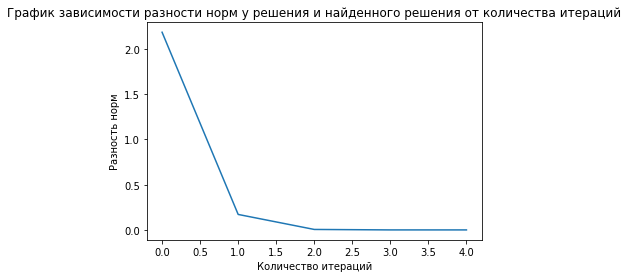

In [357]:
xxx = [i for i in range(5)]
import matplotlib.pyplot as plt
plt.figure()
plt.plot(xxx,[np.linalg.norm(f2(A,b,x1,i) - x) for i in xxx])
plt.title('График зависимости разности норм у решения и найденного решения от количества итераций')
plt.ylabel('Разность норм')
plt.xlabel('Количество итераций')
plt.show()

Как мы видели при такой ситуации, когда у матрицы A диагональные элементы доминируют будет сходимость и видим, что после 2 итераций уже почти ничего не меняется.


Посмотрим, что будет для другой матрицы

Для этого найдем "истинное" решение этой системы, и посмотрим, что будет, когда будем приближать нашим методом

In [358]:
np.fill_diagonal(A, 1e-2)
A

array([[0.01      , 0.90008784, 0.7791638 , 0.59915478, 0.29112524],
       [0.15139526, 0.01      , 0.65755178, 0.07334254, 0.0550064 ],
       [0.32319481, 0.5904818 , 0.01      , 0.28706243, 0.17306723],
       [0.13402121, 0.99465383, 0.17949787, 0.01      , 0.5682914 ],
       [0.00934857, 0.90064862, 0.97724143, 0.55689468, 0.01      ]])

In [361]:
x = np.linalg.solve(A, b)

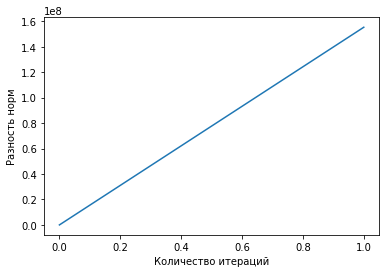

In [362]:
xxx = [i for i in range(2)]
import matplotlib.pyplot as plt
plt.figure()
plt.plot(xxx,[np.linalg.norm(f2(A,b,x1,i) - x) for i in xxx])
#plt.title('График зависимости разности норм у решения и найденного решения от количества итераций')
plt.ylabel('Разность норм')
plt.xlabel('Количество итераций')
plt.show()

Как видно, даже при одной итерации разница так быстро растет, что достигает порядка 1е9. Это происходит из-за того, что норма нашей BB больше 1 из-за чего наше решение будет быстро расходиться. 

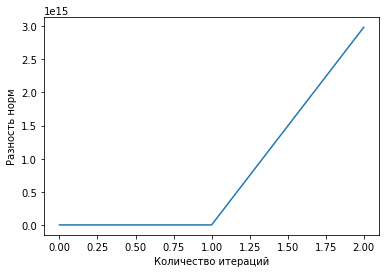

In [363]:
xxx = [i for i in range(3)]
import matplotlib.pyplot as plt
plt.figure()
plt.plot(xxx,[np.linalg.norm(f2(A,b,x1,i) - x) for i in xxx])
#plt.title('График зависимости разности норм у решения и найденного решения от количества итераций')
plt.ylabel('Разность норм')
plt.xlabel('Количество итераций')
plt.show()

А тут уже 2 итерации произошло, и видно, как сильно выросла разница в нормах, то есть если диагональные элементы будут одного порядка по сравнению с остальными, то такой способ вообще не убдет работать, потому что даже при очень маленьком количестве итераций будет сильно расходиться решение.

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

In [ ]:
# ... ENTER YOUR CODE HERE ...